In [1]:
import numpy as np
from PIL import Image
import glob
import os

Let's get acquainted with our data.

In [2]:
class_names = {}
idx = 0
path = r".\sketches_png\png\*"
image_data = []
label = []
for class_path in glob.glob(path):
    head_tail = os.path.split(class_path) 
    class_names[head_tail[1]] = idx
    idx += 1
class_names_inv = {key:val for val, key in class_names.items()}
print(class_names)
print(len(class_names))

{'airplane': 0, 'alarm clock': 1, 'angel': 2, 'ant': 3, 'apple': 4, 'arm': 5, 'armchair': 6, 'ashtray': 7, 'axe': 8, 'backpack': 9, 'banana': 10, 'barn': 11, 'baseball bat': 12, 'basket': 13, 'bathtub': 14, 'bear (animal)': 15, 'bed': 16, 'bee': 17, 'beer-mug': 18, 'bell': 19, 'bench': 20, 'bicycle': 21, 'binoculars': 22, 'blimp': 23, 'book': 24, 'bookshelf': 25, 'boomerang': 26, 'bottle opener': 27, 'bowl': 28, 'brain': 29, 'bread': 30, 'bridge': 31, 'bulldozer': 32, 'bus': 33, 'bush': 34, 'butterfly': 35, 'cabinet': 36, 'cactus': 37, 'cake': 38, 'calculator': 39, 'camel': 40, 'camera': 41, 'candle': 42, 'cannon': 43, 'canoe': 44, 'car (sedan)': 45, 'carrot': 46, 'castle': 47, 'cat': 48, 'cell phone': 49, 'chair': 50, 'chandelier': 51, 'church': 52, 'cigarette': 53, 'cloud': 54, 'comb': 55, 'computer monitor': 56, 'computer-mouse': 57, 'couch': 58, 'cow': 59, 'crab': 60, 'crane (machine)': 61, 'crocodile': 62, 'crown': 63, 'cup': 64, 'diamond': 65, 'dog': 66, 'dolphin': 67, 'donut': 6

There are 250 classes, with 20k images in total. Each of them has a single channel, but are (1111 x 1111) pixels. This means the dataset is too large to be loaded at once.

This is a typical problem. We could explore common approaches: storing the data in a Relational Database and querying batches through SQL, progressively loading the data, etc.

However, I decided to downsample them as a first approach.

In [3]:
image_arr = []
class_idx = 0
for example_path in glob.glob(path[:-1] + class_names_inv[class_idx] + "\*"):
    with Image.open(example_path) as im:
        image_arr.append(np.array(im.resize((128, 128), Image.BICUBIC)))
print(len(image_arr))

C:\Users\Felipe\AppData\Local\Temp\ipykernel_10972\2000480947.py:5: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  image_arr.append(np.array(im.resize((128, 128), Image.BICUBIC)))


80


Let's visualize some data.

In [4]:
import matplotlib.pyplot as plt

(128, 128)


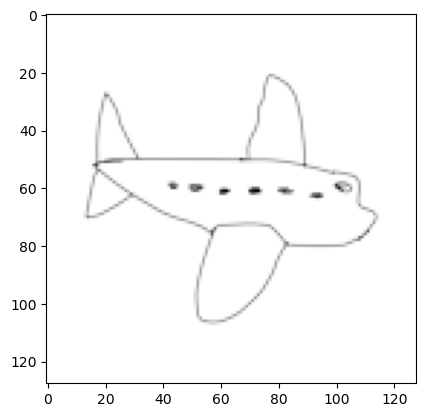

In [5]:
plt.imshow(image_arr[0], cmap="Greys_r")
print(image_arr[0].shape)

A good idea is to have a helper function to load all data from a given class.

In [6]:
def load_class(class_idx, class_names_inv, root_path, image_shape=(128, 128)):
    class_name = class_names_inv[class_idx]
    class_path = root_path[:-1] + f"{class_name}\\*"
    data = []
    for example_path in glob.glob(class_path):
        with Image.open(example_path) as im:
            data.append(np.array(im.resize(image_shape, Image.Resampling.BICUBIC)))
    label = class_idx*np.ones(len(data))
    data = np.array(data)
    return data, label

I can also explore `torchvision.utils.make_grid` utility function for plotting grids of images.

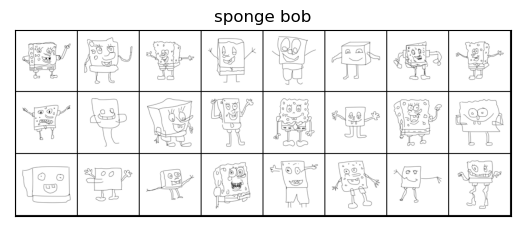

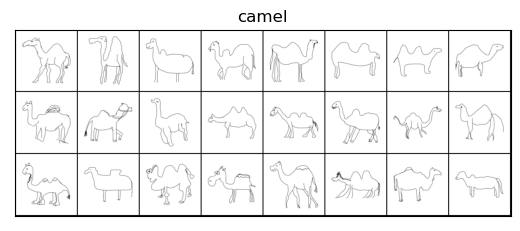

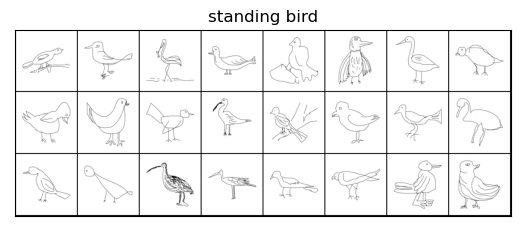

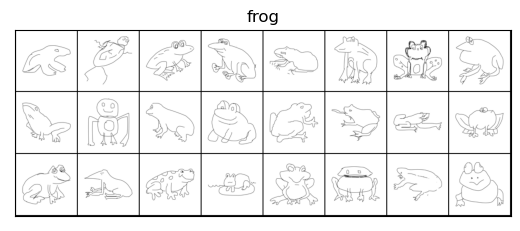

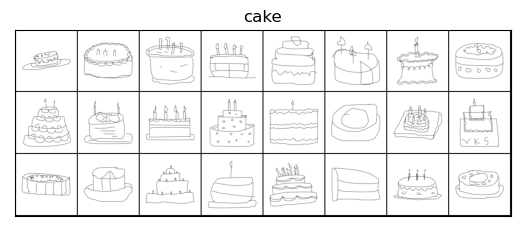

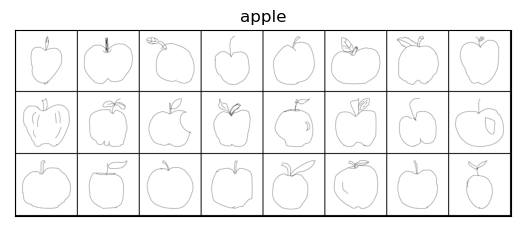

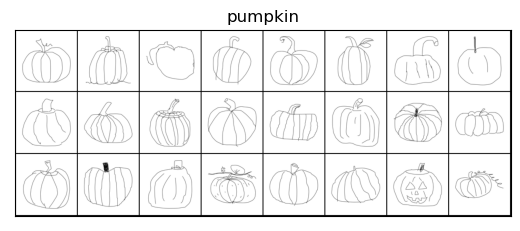

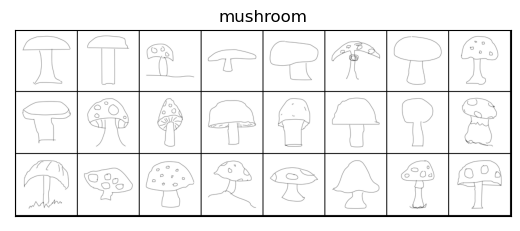

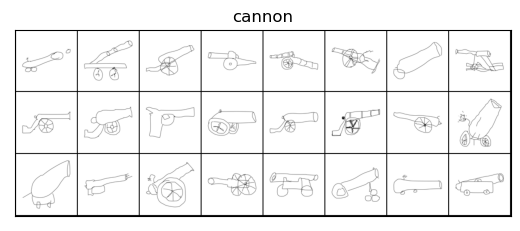

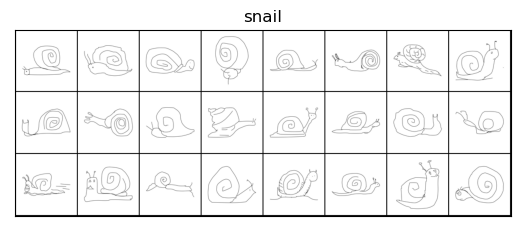

In [37]:
import torch
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision

def show_make_grid(imgs, labels):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axs[0, i].set_title(class_names_inv[labels[i].item()])
    
rng = np.random.default_rng()
random_idx = rng.choice(len(class_names)+1, size=10, replace=False)
for idx in random_idx:
    data_arr, label_arr = load_class(idx, class_names_inv, path)
    batch_size = 24
    data = torch.tensor(data_arr)
    data = data.unsqueeze(1)
    labels = torch.tensor(label_arr)
    image_grid = make_grid(data[:batch_size])
    show_make_grid(image_grid, labels)
    plt.show()

With the downsampling (1111 x 1111) $\to$ (128, 128), we have effectively reduced the volume of data by a factor of $\approx$ 75. This allows loading everything at once.

Let's build a data loader from the previous class loader.

In [55]:
def load_data(root_path, class_names_inv, image_shape=(128, 128)):
    N_classes = len(class_names_inv)
    for class_idx in range(N_classes):
        class_data, class_label = load_class(class_idx, class_names_inv,
                                             root_path=root_path, image_shape=image_shape)
        class_data = torch.tensor(class_data)
        class_label = torch.tensor(class_label)
        if class_idx == 0:
            data = class_data
            label = class_label
        else:
            data = torch.vstack((data, class_data))
            label = torch.hstack((label, class_label))
    return data.unsqueeze(1), label.squeeze()

In [56]:
data, label = load_data(path, class_names_inv)

In [57]:
print(f"total: {data.shape}, labels: {label.shape}")

total: torch.Size([20000, 1, 128, 128]), labels: torch.Size([20000])


A good practice, since we will be working with PyTorch, is to subclass `torch.utils.data.Dataset`, as instructed [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

This will allow us to load mini-batches using a `torch.utils.data.DataLoader`, making life easier.

In [ ]:
class SketchDataset(Dataset):
    def __init__(self, *args, **kwargs):
        ### TO DO ###
        
        ### *** ###

    def __len__(self):
        ### TO DO ###
        
        ### *** ###
        return None

    def __getitem__(self, idx):
        ### TO DO ###
        
        ### *** ###
        return data, label